Plots that need to be made:
1. search efficiency and cost as a function of itterations
    - put SFBO, MFBO, and random search on the same plot
2. MFBO PCA


For these plots I will need the feature data, selectivities, costs, and search results. 
In the search results, I will need the acquired COF ID and fidelity.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle # for .pkl files
import h5py   # for .jld2 files
import os
# import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

plt.rcParams.update({'font.size': 16})

## Load Data

In [2]:
###
#  Features and Molecular Simulation Data
###
file = h5py.File("targets_and_normalized_features.jld2", "r")
# feature matrix
X = torch.from_numpy(np.transpose(file["X"][:])) # ... Needs to be tensor?
# simulation data
y = [np.transpose(file["henry_y"][:]), 
     np.transpose(file["gcmc_y"][:])]

####### do I even need to import the costs since they are included in the dictionaries?
# I gues it is helpful to have all of the costs and not jus the once for the acquired COFs
# ... maybe.
# associated simulation costs
cost = [np.transpose(file["henry_total_elapsed_time"][:]), 
        np.transpose(file["gcmc_elapsed_time"][:])]



# total number of COFs in data set
nb_COFs = X.shape[0]

In [3]:
###
#  Bayesian Optimization Data
###
# dict_keys(['acquired_set', 'cost_acquired'])
mfbo_res = pickle.load(open('search_results/mfbo_results_with_EI.pkl', 'rb'))

# dict_keys(['ids_acquired', 'y_acquired', 'cost_acquired'])
sfbo_res = pickle.load(open('search_results/sfbo_results_with_EI.pkl', 'rb'))

# dict_keys(['ids_acquired', 'y_rs_max_mu', 'y_rs_max_sig_bot', 'y_rs_max_sig_top'])
random_search_res = pickle.load(open('search_results/random_search_results.pkl', 'rb'))

In [4]:
# check that BO runs are the same length
assert mfbo_res['acquired_set'].size()[0] == len(sfbo_res['ids_acquired'])

## Search Efficientcy Curves

In [5]:
nb_COFs_initialization = 3
iterations = range(len(sfbo_res['ids_acquired'])) 
iterations

range(0, 100)

In [6]:
def accumulated_cost(cost_acquired):
    accumulated_cost = np.zeros(len(cost_acquired))
    c = 0
    for i in range(len(cost_acquired)):
        c += cost_acquired[i]
        # accumulated cost
        accumulated_cost[i] = c
        
    return accumulated_cost

In [7]:
mfbo_res['acquired_set'][:6]

tensor([[  0,  25],
        [  1,  25],
        [  0, 494],
        [  1, 494],
        [  0, 523],
        [  1, 523]])

In [21]:
sfbo_res['y_acquired']

tensor([ 3.8313,  1.8507, 14.0175, 15.7661, 12.3506,  6.8957,  2.9035,  4.3554,
         1.6962,  1.0581,  0.0940,  4.5762,  4.2687,  4.2931,  6.9930,  2.9021,
        11.7285,  0.7202, 10.6691,  5.2524,  6.2627, 18.5345, 18.3960,  9.1384,
        18.1710, 14.9923, 12.4940,  6.2482,  3.7308,  6.9058, 16.8510,  5.6353,
         1.0959,  3.1851,  7.0477,  6.7175,  9.2798,  6.2371,  3.7551,  5.2722,
         3.2030,  3.2699,  6.2316,  6.8810,  2.6149,  5.5845,  3.6542,  6.4738,
         3.7307,  3.4705,  0.0228,  6.6776,  9.6504,  1.8097,  2.8001,  3.9639,
         4.8875,  4.1649,  3.7609,  3.8803,  5.5103,  3.8098,  4.2125,  3.2009,
         3.4956, 10.6860,  2.9121,  4.8710,  2.3682,  3.8905,  4.8020,  2.6089,
         4.0275,  3.8790,  3.5010,  3.0984,  4.3849, 10.9051,  5.6304,  2.7921,
         3.7405,  3.9372,  3.8364,  3.1229,  6.9544,  4.2503,  9.9071,  2.6217,
         3.3494,  3.7222,  2.8086,  7.7283,  3.5780,  3.7966,  2.7352,  2.3023,
         4.6242,  2.2508, 15.2473,  5.50

In [20]:
max(sfbo_res['y_acquired'][:1].detach().numpy())

3.8312762487603047

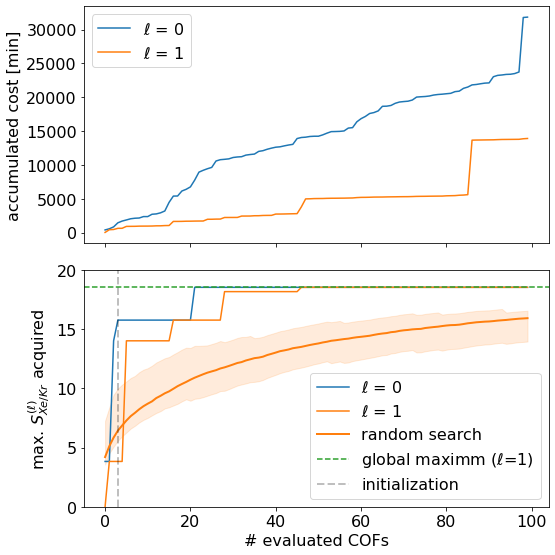

In [24]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8))  

for i, res in enumerate([sfbo_res, mfbo_res]):   
    ###
    #  Cost
    #  - include random search with bounds
    ###
    acc_cost = accumulated_cost(res['cost_acquired'].detach().numpy()) 
    ax[0].plot(iterations, acc_cost, label="$\ell$ = " + str(i))
    
    ###
    #  Search Efficiency Curves
    #  - SFBO and MFBO
    ###
    y_max = 0
    y_max_at_iter = []
    if i == 0: # sfbo => high-fidelity
        y_max_at_iter = [max(res['y_acquired'][:i+1].detach().numpy()) for i in range(len(res['y_acquired']-1))]        
    else:
        # we want the maximum y value (only high-fidelity) up to a given iteration
        for f_id, cof_id in mfbo_res['acquired_set']:
            if f_id == 1 and y[f_id][cof_id] > y_max:
                y_max = y[f_id][cof_id]
                
            y_max_at_iter.append(y_max)

    ax[1].plot(iterations, y_max_at_iter, label="$\ell$ = " + str(i))

    
# Random Search (at low-fidelity)
ax[1].plot(iterations, random_search_res['y_rs_max_mu'], label="random search", color="tab:orange", lw=2)
ax[1].fill_between(iterations, random_search_res['y_rs_max_mu'] - random_search_res['y_rs_max_sig_bot'], 
                 random_search_res['y_rs_max_mu'] + random_search_res['y_rs_max_sig_top'], 
                 color="tab:orange", alpha=0.15)


# max y and initializations
ax[1].axhline(y=max(y[1]), label="global maximm ($\ell$=1)", color="tab:green", ls="--", lw=1.5)
ax[1].axvline(x=nb_COFs_initialization, label="initialization", color="k", alpha=0.25, linestyle="--", lw=2)



ax[0].set_ylabel("accumulated cost [min]")
ax[0].legend()

ax[1].set_ylabel("max. $S^{(\ell)}_{Xe/Kr}$ acquired")
ax[1].set_ylim(ymin=0, ymax=20)
ax[1].set_xlabel("# evaluated COFs")
ax[1].legend()

plt.tight_layout()
# plt.savefig("./figs/cost_and_search_efficiency.pdf", format="pdf")
plt.show()

In [ ]:



# ax1 = plt.subplot(2, 1, 1)
# plt.axvline(x=nb_COFs_initialization, 
#             label="initialization", color="k", alpha=0.25, linestyle="--", lw=2)
# plt.plot(iterations, accumulated_cost, label="cost", color="tab:blue")
# plt.legend(fontsize=12)
# plt.ylabel("accumulated cost [min]")
# plt.xlim(xmin=0, xmax=nb_iterations)
# plt.setp(ax1.get_xticklabels(), visible=False)
# plt.ylim(ymin=0, ymax=35000)

# plt.subplot(2, 1, 2, sharex=ax1)
# plt.axhline(y=max(y), label="global maximm", color="tab:green", ls="--", lw=1.5)
# plt.axvline(x=nb_COFs_initialization, label="initialization", color="k", alpha=0.25, linestyle="--", lw=2)
# plt.plot(iterations, y_max, label="BO", color="tab:red", zorder=3)

## Pirinciple Component Analysis

**TODO:**
- shuffle points before plotting to remove any bias... try sklearn.utils shuffle(array)

In [ ]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

In [ ]:
cmap_name = cm.summer # sequential colormaps: spring, summer, autumn, viridis, Wistia, hot, copper
# color_map = cm.cmap_name
# plt.scatter(x, y, c=t, cmap=cm.cmap_name)

In [ ]:
fig = plt.figure()
#low dimensional (PCA) visualization of the entire dataset
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name, s=10, alpha=0.6)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.03, pad=0.04)
cb.set_label(label="$S^{(\ell=1)}_{Xe/Kr}$")
plt.xticks()
plt.yticks()

plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
# plt.savefig("./figs/PCA_feature_space_colored_by_GCMC_Selectivity.pdf", dpi=600, format="pdf")
plt.show()

In [ ]:
nb_acquired = [2*nb_COFs_initialization, 30, 60]

fig, ax = plt.subplots(1, len(nb_acquired), sharey=True, sharex=True, figsize=[3*6.4, 4.8] )

for i, nb in enumerate(nb_acquired):
    acq = mfbo_res['acquired_set'][:nb]
    lf_acq = acq[acq[:, 0] == 0, :] # low-fidelity
    hf_acq = acq[acq[:, 0] == 1, :] # high-fidelity
    assert len(lf_acq) + len(hf_acq) == len(acq)
    ###
    #  plot PCA for all COFs
    ###
    pca_base = ax[i].scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name,
                             facecolor='none', s=10, alpha=0.6) 
    if i == 2: # include colorbar
        cb = plt.colorbar(pca_base, fraction=0.03, pad=0.04, ax=ax[2])
        cb.set_label(label="$S^{(\ell=1)}_{Xe/Kr}$")
    ###
    #  indicate acquired points at the given iteration
    ###
    # low-fidelity
    ax[i].scatter(X_2D[lf_acq[:nb, 1], 0], X_2D[lf_acq[:nb, 1], 1], 
                  label="$\ell=0$",
                  color='k', marker='x', s=20, lw=0.5) 
    # high-fidelity
    ax[i].scatter(X_2D[hf_acq[:nb, 1], 0], X_2D[hf_acq[:nb, 1], 1], 
                  label="$\ell=1$",
                  color='r', marker='+', s=20, lw=0.5, zorder=1)
    # subplot titles
    if i == 0:
        ax[i].set_title('(initialization)\n{} acquired COFs'.format(nb_acquired[i]))
    else:
        ax[i].set_title('{} acquired COFs'.format(nb_acquired[i]))
        
    ax[i].tick_params(axis='x')
    ax[i].set_aspect('equal', 'box')
    

ax[0].legend()
ax[0].set_ylabel('PC 2')
ax[2].tick_params(axis='y', labelsize=0)
    
fig.text(0.52, -0.02, 'PC 1', ha='center')
plt.tight_layout()
# plt.savefig("./figs/MFBO_PCA_multiple_iterations.pdf", bbox_inches="tight", dpi=600, format="pdf")
plt.show()